# Predicting Airbnb Listing Prices in Seattle

By: Josh Keating, Ethan Katnic, Christian Hahn, Robin Yang

## Framing the Problem

The purpose of this project is to identify the aspects of Airbnb host listings that have a correlation to the frequency of achieving bookings. This information will allow Airbnb hosts to find and improve certain variables of their listing that can increase their number of bookings. The dataset used was the Seattle Airbnb Open Dataset found on Kaggle (https://www.kaggle.com/airbnb/seattle#calendar.csv). The two CSV files we are using from this set are calendar.csv and listings.csv. The calendar file displays the listing_id, the dates, whether it is available on that date, and the price of booking for that day. The listings file includes a wide variety of metadata scraped from the listing url.

On top of the given columns in the dataset, we used the Microsoft Azure Text Sentiment Analysis API to calculate the sentiment value (on a scale of 1 - 100) of the listing summary. Positive and negative sentiment can be identified and perhaps has a correlation to number of bookings. This was done using post requests on Postman and is known as scores.csv. 

## Import Libraries and Data

In [13]:
#import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from sklearn.neural_network import MLPRegressor

In [2]:
# read in clean data
airbnb_data_dummies = pd.read_csv('data/cleaned-listings-dummies.csv')
airbnb_data_basic = pd.read_csv('data/cleaned-listings-base.csv')


In [3]:
# Rename features with spaces in their names
airbnb_data_dummies.rename(index=str, columns={
    'neighbourhood_Beacon Hill': 'neighbourhood_Beacon_Hill',
    'neighbourhood_Capitol Hill': 'neighbourhood_Capitol_Hill',
    'neighbourhood_Central Area': 'neighbourhood_Central_Area',
    'neighbourhood_Lake City': 'neighbourhood_Lake_City',
    'neighbourhood_Other neighborhoods': 'neighbourhood_Other_neighborhoods',
    'neighbourhood_Queen Anne': 'neighbourhood_Queen_Anne',
    'neighbourhood_Rainier Valley': 'neighbourhood_Rainier_Valley',
    'neighbourhood_Seward Park': 'neighbourhood_Seward_Park',
    'neighbourhood_University District': 'neighbourhood_University_District',
    'neighbourhood_West Seattle': 'neighbourhood_West_Seattle',
    'property_type_Bed & Breakfast': 'property_type_Bed_Breakfast',
    'room_type_Entire home/apt': 'room_type_Entire_home_apt',
    'room_type_Private room': 'room_type_Private_room',
    'room_type_Shared room': 'room_type_Shared_room'
}, inplace=True)


In [4]:
# list(airbnb_data_dummies.columns.values)
# airbnb_data_dummies

### Use this regression to defend our feature selection

In [5]:
formula = 'price ~ host_response_rate + accommodates + guests_included + bathrooms + bedrooms + beds + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + score + host_is_superhost_f + host_is_superhost_t + neighbourhood_Ballard  + neighbourhood_Cascade  + neighbourhood_Delridge + neighbourhood_Downtown + neighbourhood_Interbay + neighbourhood_Magnolia + neighbourhood_Northgate + property_type_Apartment  + property_type_Condominium + property_type_House + property_type_Loft + property_type_Townhouse + neighbourhood_Beacon_Hill + neighbourhood_Capitol_Hill + neighbourhood_Central_Area + neighbourhood_Lake_City + neighbourhood_Other_neighborhoods + neighbourhood_Queen_Anne + neighbourhood_Rainier_Valley + neighbourhood_Seward_Park + neighbourhood_University_District + neighbourhood_West_Seattle + property_type_Bed_Breakfast + room_type_Entire_home_apt + room_type_Private_room + room_type_Shared_room'

mod1 = smf.ols(formula=formula, data=airbnb_data_dummies).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     130.4
Date:                Mon, 03 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:37:11   Log-Likelihood:                -20310.
No. Observations:                3705   AIC:                         4.070e+04
Df Residuals:                    3665   BIC:                         4.095e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -27.1842     12.141     -2.239      0.025     -50.988      -3.380
host_response_rate                   -0.1517      0.089     -1.697      0.090      -0.327       0.024
accommodates                          7.5074      1.171      6.412      0.000       5.212       9.803
guests_included                       3.3175      0.877      3.781      0.000       1.597       5.038
bathrooms                            27.5263      2.229     12.350      0.000      23.156      31.896
bedrooms                             32.3673      2.044     15.832      0.000      28.359      36.376
beds                                  1.0758      1.777      0.605      0.545      -2.408       4.560
number_of_reviews                    -0.1538      0.028     -5.505      0.000      -0.209      -0.099
review_scores_rating                  0.6969      0.265      2.628      0.009       0.177       1.217
review_scores_accuracy                2.7688      2.038      1.359      0.174      -1.226       6.764
review_scores_cleanliness             2.4932      1.785      1.397      0.163      -1.007       5.993
review_scores_checkin                -0.5157      2.521     -0.205      0.838      -5.458       4.426
review_scores_communication           0.3984      2.704      0.147      0.883      -4.904       5.701
review_scores_location                4.4394      1.965      2.260      0.024       0.588       8.291
review_scores_value                  -8.4751      2.048     -4.137      0.000     -12.491      -4.459
score                                -3.3947      5.496     -0.618      0.537     -14.170       7.381
host_is_superhost_f                 -17.1693      5.925     -2.898      0.004     -28.786      -5.553
host_is_superhost_t                 -10.0149      6.471     -1.548      0.122     -22.702       2.672
neighbourhood_Ballard                -6.1167      4.200     -1.456      0.145     -14.351       2.118
neighbourhood_Cascade                24.6326      6.376      3.863      0.000      12.131      37.134
neighbourhood_Delridge              -23.7760      6.513     -3.650      0.000     -36.546     -11.006
neighbourhood_Downtown               33.8814      3.415      9.921      0.000      27.186      40.577
neighbourhood_Interbay                9.2145     17.548      0.525      0.600     -25.189      43.618
neighbourhood_Magnolia               18.0461      7.335      2.460      0.014       3.665      32.427
neighbourhood_Northgate             -29.7396      6.748     -4.407      0.000     -42.970     -16.509
property_type_Apartment             -15.7871      3.440     -4.590      0.000     -22.531      -9.043
property_type_Condominium           -10.5923      6.149     -1.723      0.085     -22.647       1.463
property_type_House    

In [6]:
# mod1_pred = mod1.predict(airbnb_data_dummies)
# mod1_pred

## Data Visualizations

A heatmap to view the correlations between variables right off the bat. The values are squared to see simple correlations rather than including negative correlations. We are most interested in those that are correlated with price, whcih include the number it accomodates nd number of bedrooms.

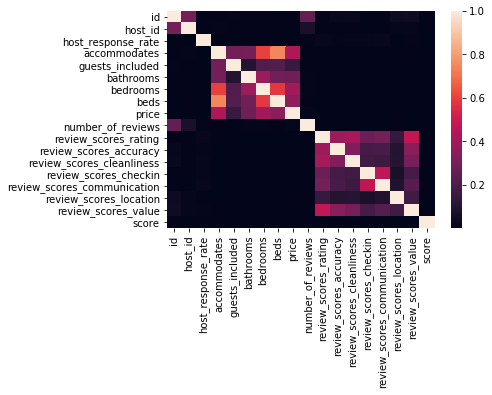

In [3]:
sns.heatmap(airbnb_data_basic.corr()**2)

Using the sentiment score calculated from the listing description, we visualized it against price. It was interesting to see that the few that had low sentiment had the lowest prices. Most tended to have high sentiment, which was expected as the descriptions are intended to sell the home.

Text(0.5,1,'Sentiment Score vs. Price')

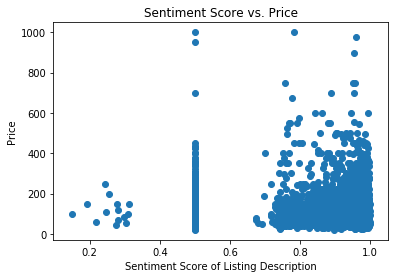

In [4]:
plt.scatter(airbnb_data_basic['score'], airbnb_data_basic['price'])
plt.xlabel('Sentiment Score of Listing Description')
plt.ylabel('Price')
plt.title('Sentiment Score vs. Price')

We also graphed the ten most expensive and least expensive neighborhoods. Housing prices are highly dependent on location and we believe that Airbnb prices will reflect the same thing. The neighborhood will likely have a high correlation with price.

Text(0.5,1,'Ten Most Expensive Neighborhoods')

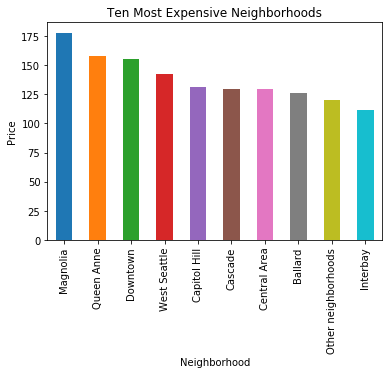

In [5]:
prices_by_neighbourhood = airbnb_data_basic.groupby(['neighbourhood']).mean().price.sort_values(ascending=False)
ten_most_expensive = prices_by_neighbourhood.head(10).plot.bar()
ten_most_expensive.set_xlabel('Neighborhood')
ten_most_expensive.set_ylabel('Price')
ten_most_expensive.set_title('Ten Most Expensive Neighborhoods')

Text(0.5,1,'Ten Least Expensive Neighborhoods')

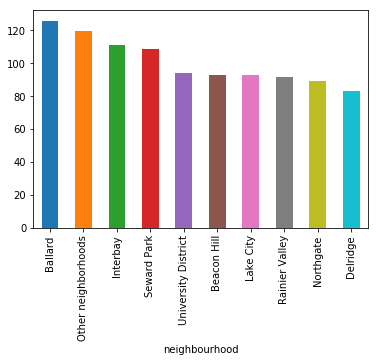

In [6]:
ten_least_expensive = prices_by_neighbourhood.tail(10).plot.bar()
ten_most_expensive.set_xlabel('Neighborhood')
ten_most_expensive.set_ylabel('Price')
ten_most_expensive.set_title('Ten Least Expensive Neighborhoods')

The graph below shows the listing price graphed against the number of reviews. The graph cascades down nicely and shows that higher priced listings have a significantly lower number of reviews. This is most likely due to them being out of affordable range for most.

Text(0.5,1,'Price of Listing vs. Number of Reviews')

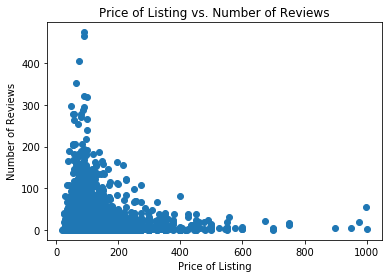

In [7]:
plt.scatter(airbnb_data_basic['price'], airbnb_data_basic['number_of_reviews'])
plt.xlabel('Price of Listing')
plt.ylabel('Number of Reviews')
plt.title('Price of Listing vs. Number of Reviews')

### Split data into Training and Test Sets

In [7]:
# split into train and test
train_features, test_features, train_outcome, test_outcome = train_test_split(
    airbnb_data_dummies.drop("price", axis=1),
    airbnb_data_dummies.price,
    test_size=0.20
)

### TODO: look at adding a variance thresh 

In [8]:
# KNN pipeline
knn_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(),
    KNeighborsRegressor(n_neighbors=4, weights="distance")
)

In [9]:
# Grid
knn_param_grid = {
              'polynomialfeatures__degree':range(1,2)
}

In [10]:
# RF
rf_pipeline = make_pipeline(
    SelectKBest(),
    MinMaxScaler(),
    PolynomialFeatures(1),
    RandomForestRegressor()
)

In [11]:
# RF Grid
rf_param_grid = { 
              'selectkbest__k':['all'],
              'randomforestregressor__n_estimators':range(1,100, 5),
              'randomforestregressor__max_depth':range(1,5)
}

In [14]:
# Neural Network Pipeline
nn_pipeline = make_pipeline(
    MinMaxScaler(),
    SelectKBest(),
    PolynomialFeatures(1),
    MLPRegressor()
)

In [15]:
nn_param_grid = {
              'selectkbest__k':['all'],
              'mlpregressor__learning_rate':["constant", "invscaling", "adaptive"],
              'mlpregressor__solver':["lbfgs", "sgd", "adam"],
              'mlpregressor__activation':["relu"]
}


In [16]:
nn_grid = GridSearchCV(nn_pipeline, nn_param_grid, cv=3, scoring="neg_mean_absolute_error")
nn_grid.fit(train_features, train_outcome)
nn_grid.score(test_features, test_outcome)

-32.018833217291096

In [17]:
nn_grid.best_params_

{'mlpregressor__activation': 'relu',
 'mlpregressor__learning_rate': 'adaptive',
 'mlpregressor__solver': 'sgd',
 'selectkbest__k': 'all'}

In [13]:
grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-35.55261833854876

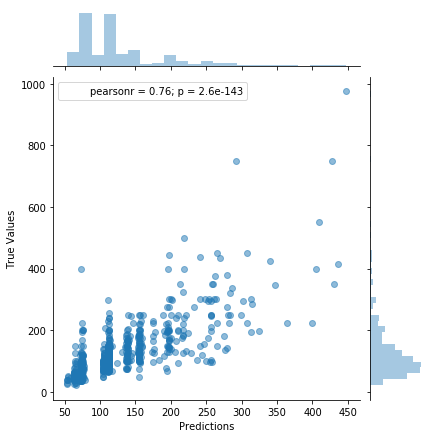

In [14]:
ax = sns.jointplot(x=grid.predict(test_features), y=test_outcome)
ax = (ax.set_axis_labels("Predictions", "True Values"))
plt.show(ax)

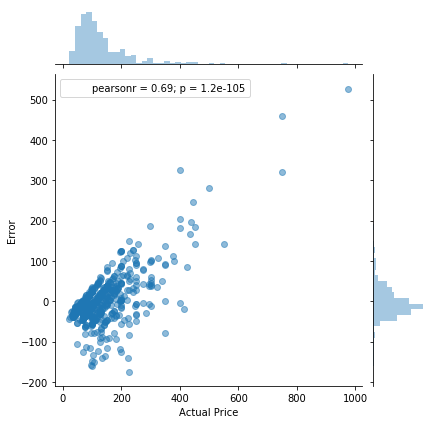

In [37]:
ax = sns.jointplot(x=test_outcome, y=test_outcome - grid.predict(test_features), alpha = .5)
ax = (ax.set_axis_labels("Actual Price", "Error"))
plt.show(ax)